# Imports

In [1]:
import os
import pickle
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load Data

In [3]:
# Folder containing the datset
data_dir = '../dataset/processed_topic_data'

In [4]:
def load_data(filename, data_dir, data_type):
    h5f = h5py.File(os.path.join(data_dir, filename), 'r')
    data = h5f[data_type][:]
    h5f.close()
    return data

Load training data

In [11]:
train_images = load_data('train_images.h5', data_dir, 'images')

In [12]:
train_categories = load_data('train_categories.h5', data_dir, 'labels')

Load validation data

In [5]:
val_images = load_data('val_images.h5', data_dir, 'images')

In [6]:
val_categories = load_data('val_categories.h5', data_dir, 'labels')

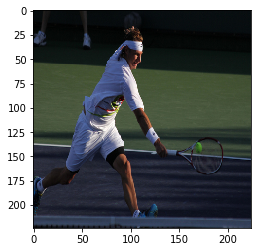

In [8]:
plt.imshow(val_images[0])
plt.show()

Load test data

In [15]:
test_images = load_data('test_images.h5', data_dir, 'images')

In [16]:
test_categories = load_data('test_categories.h5', data_dir, 'labels')

Load mapping

In [20]:
with open('../dataset/coco_raw.pickle', 'rb') as file:
    coco_raw = pickle.load(file)
id_category = coco_raw['id_category']

In [21]:
num_classes = len(id_category)
num_classes

80

In [22]:
num_images_train = train_images.shape[0]
num_images_train

19324

### Display a sample image

person
skis


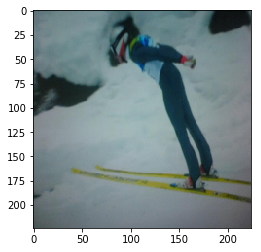

In [23]:
# display image
idx = 10

for category, value in enumerate(train_categories[idx]):
    if value != 0:
        print(id_category[category])

plt.imshow(train_images[idx])
plt.show()

# Define Model

In [24]:
# Download VGG19 model along with the fully-connected layers
model = VGG19(include_top=True, weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [25]:
# Extract the second last fully connected layer
conv_layer = model.get_layer('fc2')

In [26]:
conv_layer.output

<tf.Tensor 'fc2/Relu:0' shape=(?, 4096) dtype=float32>

In [27]:
# Create model
conv_model = Model(inputs=model.input, outputs=conv_layer.output)

In [28]:
# Start a new Keras Sequential model
image_model = Sequential()

# Add the VGG19 model
image_model.add(conv_model)

# Add the final layer for the actual classification
image_model.add(Dense(num_classes, activation='sigmoid'))

In [29]:
# Set the VGG19 layers to be non-trainable
conv_model.trainable = False
for layer in conv_model.layers:
    layer.trainable = False

In [30]:
image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 4096)              139570240 
_________________________________________________________________
dense (Dense)                (None, 80)                327760    
Total params: 139,898,000
Trainable params: 327,760
Non-trainable params: 139,570,240
_________________________________________________________________


In [31]:
# Compile the model
optimizer = Adam(lr=1e-3)

image_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

In [32]:
weights_dir = 'weights'
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

path_checkpoint = os.path.join(weights_dir, 'checkpoint.keras')

# set model callbacks
tb = TensorBoard(log_dir=os.path.join(weights_dir, 'tensorboard-logs'), histogram_freq=0, write_graph=False)
checkpoint = ModelCheckpoint(filepath=path_checkpoint, verbose=1, save_weights_only=True)
# early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

callbacks = [tb, checkpoint]

# Train Model

In [33]:
# Load previously trained model weights
try:
    image_model.load_weights(path_checkpoint)
    print('Checkpoint loaded.')
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

Checkpoint loaded.


In [ ]:
batch_size = 64
epochs = 100

In [ ]:
image_model.fit(
    x=train_images,
    y=train_categories,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(val_images, val_categories)
)

In [ ]:
# def train_data_generator(x, y, batch_size, shift_fraction=0.2, rotation_range=40, shear_range=0.2):
#     train_datagen = ImageDataGenerator(
#         rotation_range=rotation_range,
#         width_shift_range=shift_fraction,
#         height_shift_range=shift_fraction,
#         shear_range=shear_range
#     )
#     generator = train_datagen.flow(x, y, batch_size=batch_size)
#     while True:
#         x_batch, y_batch = generator.next()
#         yield (x_batch, y_batch)

In [ ]:
# image_model.fit_generator(
#     generator=train_data_generator(train_images, train_categories, batch_size),
#     steps_per_epoch=int(num_images_train / batch_size),
#     epochs=100,
#     validation_data=(val_images, val_categories),
#     callbacks=callbacks
# )

# Test Model

In [34]:
def get_predictions(image, label, id_category):
    image_batch = np.expand_dims(image, axis=0)
    predictions = image_model.predict(image_batch)
    
    prediction_labels = []
    for index, prediction_probability in enumerate(predictions[0]):
        if prediction_probability > 0.5:
            prediction_labels.append(id_category[index])
    
    true_labels = []
    for index, value in enumerate(label):
        if value == 1:
            true_labels.append(id_category[index])
    
    print('True labels:', true_labels)
    print('Predictions:', prediction_labels)
    
    print('Image:')
    plt.imshow(image)
    plt.show()

In [37]:
idx = 789

True labels: ['person', 'surfboard']
Predictions: ['person', 'surfboard']
Image:


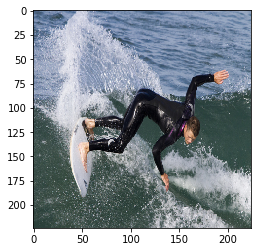

In [38]:
get_predictions(test_images[idx], test_categories[idx], id_category)

In [ ]:
get_predictions(val_images[idx], val_categories[idx], id_category)

In [ ]:
get_predictions(train_images[idx], train_categories[idx], id_category)